=== Baseline Logistic Regression (ALT > 40) ===
Test Accuracy : 0.907
Test F1       : 0.596
Test AUROC    : 0.963
Class balance (train) — positives: 0.078, test: 0.078


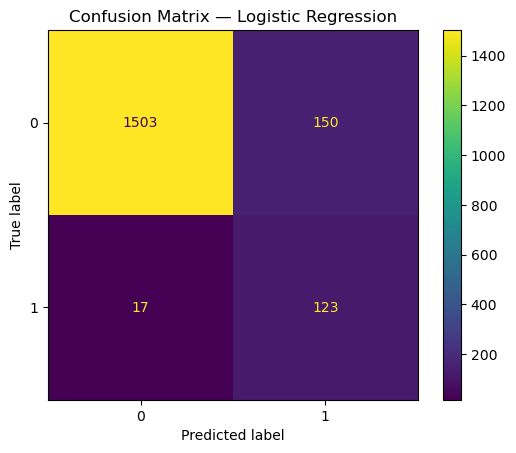

Saved: /Users/rishansujesh/Downloads/nhanes_liver/images/confusion_matrix.png


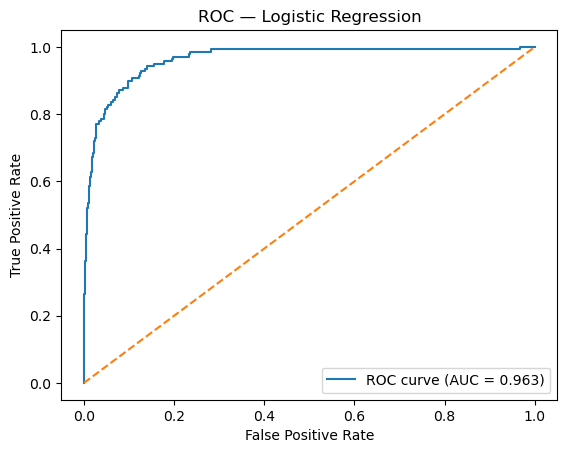

Saved: /Users/rishansujesh/Downloads/nhanes_liver/images/roc_curve.png


In [8]:
# ---- Baseline: Logistic Regression on ALT>40 --------------------------------
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    ConfusionMatrixDisplay, roc_curve, auc
)

# Paths
ROOT = Path(".").resolve()
DATA = ROOT / "nhanes_cleaned.csv"
IMG_DIR = ROOT / "images"
IMG_DIR.mkdir(exist_ok=True)

# Load
df = pd.read_csv(DATA, low_memory=False)

# Target handling
if "elevated_alt" not in df.columns:
    raise ValueError("elevated_alt not found. Re-run 00_clean_dataset.py first.")
# Drop rows with missing ALT label
df = df.dropna(subset=["elevated_alt"]).copy()
df["elevated_alt"] = df["elevated_alt"].astype(int)

# Features/target
y = df["elevated_alt"]
X = df.drop(columns=["elevated_alt", "LBXSATSI", "SEQN"], errors="ignore")  # remove raw ALT + ID

# Choose categorical vs numeric explicitly (robust to missing optional columns)
categorical_cols = [c for c in [
    "RIAGENDR", "RIDRETH1", "DMDEDUC2", "DMDMARTZ",
    # optional categoricals if present
    "SDDSRVYR", "DMDBORN4", "RIDEXMON"
] if c in X.columns]

# Everything else numeric by default
numeric_cols = [c for c in X.columns if c not in categorical_cols]

# Pipelines
numeric_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, numeric_cols),
        ("cat", categorical_pipe, categorical_cols)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# Model (balanced helps when positives are less common)
clf = LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=None)

pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", clf)
])

# Split (stratified so class ratio stays consistent)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# Fit
pipe.fit(X_train, y_train)

# Predict / Metrics
y_pred = pipe.predict(X_test)
y_prob = pipe.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred, zero_division=0)
roc = roc_auc_score(y_test, y_prob)

print("=== Baseline Logistic Regression (ALT > 40) ===")
print(f"Test Accuracy : {acc:.3f}")
print(f"Test F1       : {f1:.3f}")
print(f"Test AUROC    : {roc:.3f}")
print(f"Class balance (train) — positives: {y_train.mean():.3f}, test: {y_test.mean():.3f}")

# Confusion Matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
disp.ax_.set_title("Confusion Matrix — Logistic Regression")
cm_path = IMG_DIR / "confusion_matrix.png"
plt.savefig(cm_path, bbox_inches="tight", dpi=144)
plt.show()
print(f"Saved: {cm_path}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC — Logistic Regression")
plt.legend(loc="lower right")
roc_path = IMG_DIR / "roc_curve.png"
plt.savefig(roc_path, bbox_inches="tight", dpi=144)
plt.show()
print(f"Saved: {roc_path}")


Best threshold for F1: 0.787  |  F1: 0.735  |  Precision: 0.701  |  Recall: 0.771


Saved tuned confusion matrix to: images/confusion_matrix_tuned.png


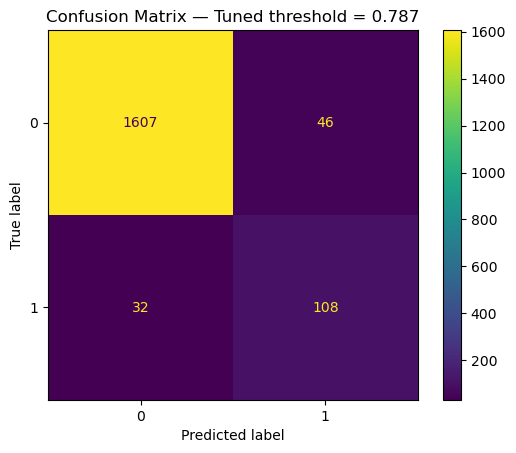

In [4]:
from sklearn.metrics import precision_recall_curve, f1_score, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import os

# Reuse y_test and y_prob from the previous cell
prec, rec, th = precision_recall_curve(y_test, y_prob)
f1s = 2 * prec * rec / (prec + rec + 1e-12)
best_idx = np.nanargmax(f1s)
best_th = th[best_idx]
best_f1 = f1s[best_idx]

print(f"Best threshold for F1: {best_th:.3f}  |  F1: {best_f1:.3f}  |  Precision: {prec[best_idx]:.3f}  |  Recall: {rec[best_idx]:.3f}")

# Make tuned predictions
y_pred_tuned = (y_prob >= best_th).astype(int)

# Create and display the confusion matrix
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_tuned)
plt.title(f"Confusion Matrix — Tuned threshold = {best_th:.3f}")

# Ensure the images folder exists
os.makedirs("images", exist_ok=True)

# Save the plot
save_path = os.path.join("images", "confusion_matrix_tuned.png")
plt.savefig(save_path, bbox_inches="tight", dpi=300)
print(f"Saved tuned confusion matrix to: {save_path}")

# Show the plot
plt.show()


=== Training and evaluating Logistic Regression ===


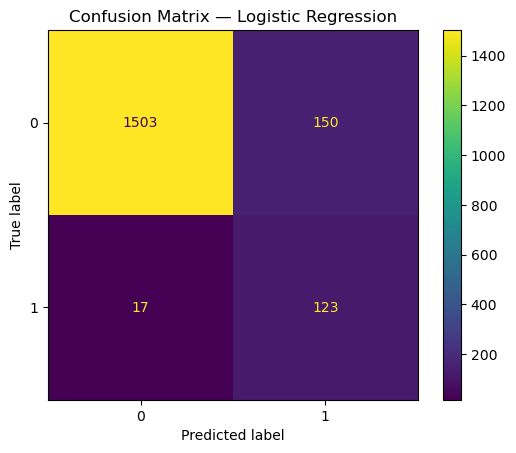

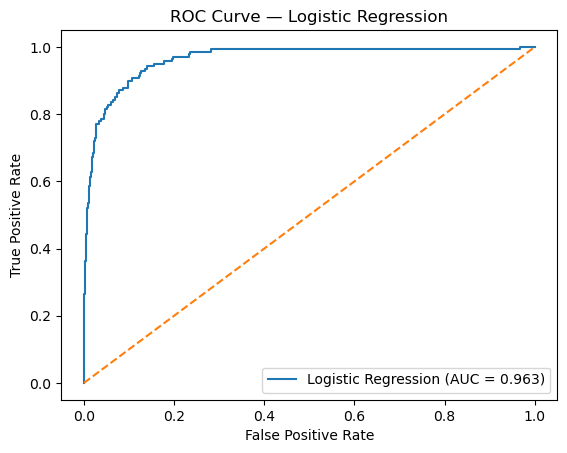

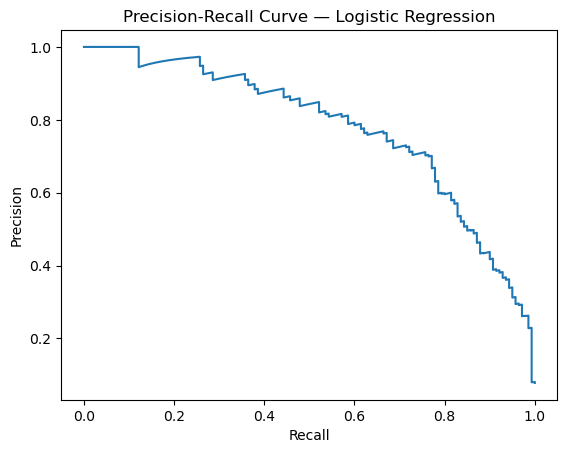

=== Training and evaluating Random Forest ===


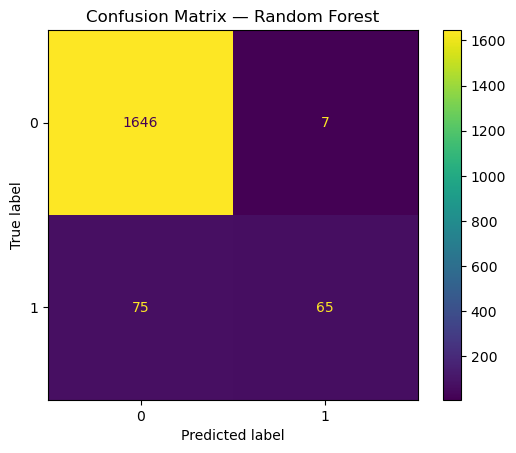

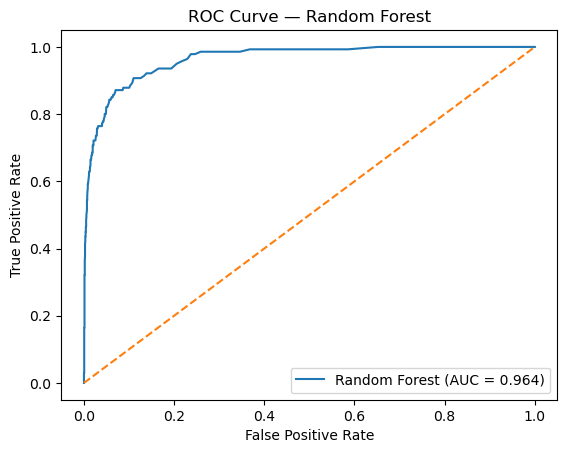

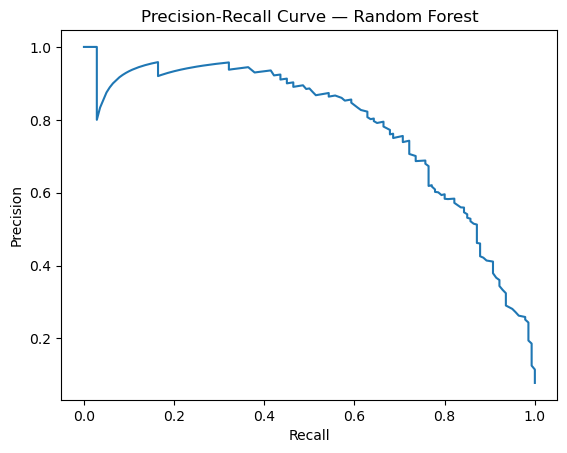

=== Training and evaluating XGBoost ===


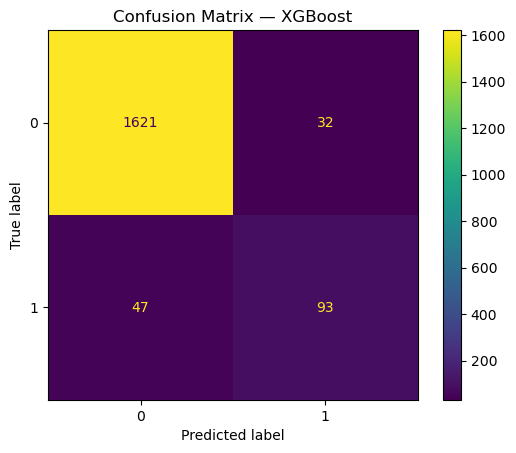

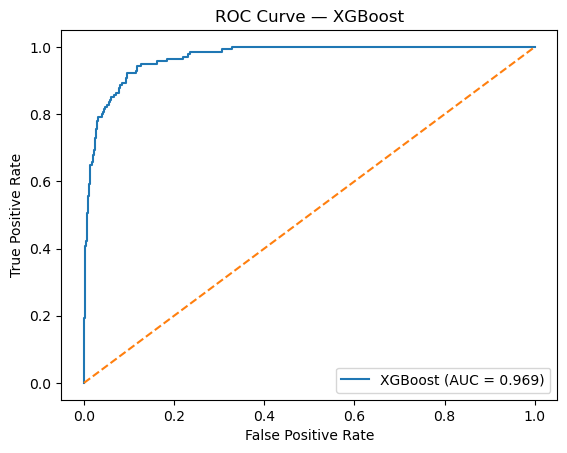

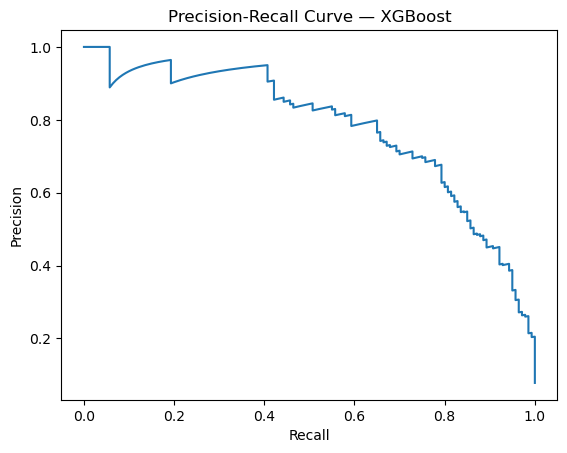


=== Model comparison (sorted by AUROC) ===
                 model  accuracy        f1     auroc
0              XGBoost  0.955940  0.701887  0.969471
1        Random Forest  0.954267  0.613208  0.963869
2  Logistic Regression  0.906860  0.595642  0.963223

Saved model comparison metrics to: /Users/rishansujesh/Downloads/nhanes_liver/results/model_comparison.csv


In [9]:
# =========================
# Cell 1: Train and evaluate LogReg, Random Forest, XGBoost
# =========================

from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    precision_recall_curve,
)

from xgboost import XGBClassifier

# If ROOT / IMG_DIR already exist from previous cell, this will just reuse them.
try:
    ROOT
except NameError:
    from pathlib import Path
    ROOT = Path(".").resolve()

IMG_DIR = ROOT / "images"
IMG_DIR.mkdir(exist_ok=True)

# X_train, X_test, y_train, y_test, numeric_cols, categorical_cols
# are assumed to already exist from the earlier baseline cell.
# If not, you need to run that cell first.

def build_preprocessor(numeric_cols, categorical_cols):
    """Create a ColumnTransformer with the same preprocessing as before."""
    numeric_pipe = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler())
    ])

    categorical_pipe = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_pipe, numeric_cols),
            ("cat", categorical_pipe, categorical_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )
    return preprocessor

def evaluate_and_plot_model(name, model, X_train, y_train, X_test, y_test,
                            numeric_cols, categorical_cols, img_dir):
    """Fit a model inside a preprocessing pipeline, compute metrics, and save plots."""
    preprocessor = build_preprocessor(numeric_cols, categorical_cols)
    pipe = Pipeline(steps=[
        ("prep", preprocessor),
        ("model", model),
    ])

    # Fit on training data
    pipe.fit(X_train, y_train)

    # Predictions and probabilities on test data
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]

    # Classification metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auroc = roc_auc_score(y_test, y_prob)

    # 1) Confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    disp.ax_.set_title(f"Confusion Matrix — {name}")
    cm_path = img_dir / f"{name.lower()}_confusion_matrix.png"
    plt.savefig(cm_path, bbox_inches="tight", dpi=144)
    plt.show()

    # 2) ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve — {name}")
    plt.legend(loc="lower right")
    roc_path = img_dir / f"{name.lower()}_roc.png"
    plt.savefig(roc_path, bbox_inches="tight", dpi=144)
    plt.show()

    # 3) Precision-Recall curve
    prec, rec, _ = precision_recall_curve(y_test, y_prob)
    plt.figure()
    plt.plot(rec, prec)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve — {name}")
    pr_path = img_dir / f"{name.lower()}_pr.png"
    plt.savefig(pr_path, bbox_inches="tight", dpi=144)
    plt.show()

    return pipe, {"model": name, "accuracy": acc, "f1": f1, "auroc": auroc}

# Define the three models with reasonable hyperparameters
logreg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
)

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    eval_metric="logloss",
)

models = {
    "Logistic Regression": logreg,
    "Random Forest": rf,
    "XGBoost": xgb,
}

fitted_pipes = {}
metrics_list = []

for name, model in models.items():
    print(f"=== Training and evaluating {name} ===")
    pipe, metrics = evaluate_and_plot_model(
        name=name,
        model=model,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        numeric_cols=numeric_cols,
        categorical_cols=categorical_cols,
        img_dir=IMG_DIR,
    )
    fitted_pipes[name] = pipe
    metrics_list.append(metrics)

# Build and display comparison table
metrics_df = pd.DataFrame(metrics_list)
metrics_df = metrics_df.sort_values("auroc", ascending=False).reset_index(drop=True)

print("\n=== Model comparison (sorted by AUROC) ===")
print(metrics_df)

# Optional: save to CSV for later use in your report
results_dir = ROOT / "results"
results_dir.mkdir(exist_ok=True)
metrics_csv_path = results_dir / "model_comparison.csv"
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"\nSaved model comparison metrics to: {metrics_csv_path}")
